In [1]:
%matplotlib inline

from copy import deepcopy
import pprint
import subprocess
from typing import Union

import asn1tools
import matplotlib.pyplot as plt
import numpy as np
import scapy.utils
from scapy.layers.inet import IP, UDP
import sigmf
from sigmf import SigMFFile

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
dataset_path = 'catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data'
dataset = sigmf.sigmffile.fromfile(dataset_path)
x = dataset.read_samples()
fs = dataset.get_global_field(SigMFFile.SAMPLE_RATE_KEY)

# Fix captures (this field was missing in the original dataset)
dataset.get_captures()[0][SigMFFile.START_INDEX_KEY] = 0

f_center = dataset.get_capture_info(0)[SigMFFile.FREQUENCY_KEY]

# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 1_876_950_000

# these are in units of samples and depend on fs (which is 7.68 Msps in this case)
Tu = 512
Ncp = 144 // 4
Ncpl = (144 + 16) // 4

# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
phase_corr = np.exp(1j*2*np.pi*((f_dc * (np.arange(7) * (Tu + Ncp)) / fs) % 1))

cfo = 18.88  # Hz
phi0 = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds
# Amplitude adjustment to get symbols of unity amplitude
x *= 24.7
# correct for CFO and phase offset
x *= np.exp(-1j*(2*np.pi*cfo/fs*np.arange(x.size) + phi0))

In [3]:
annotations = dataset.get_annotations()
GENERATOR = 'destevez Jupyter notebook'
# remove annotations introduced by this notebook
annotations = [a for a in annotations if a[SigMFFile.GENERATOR_KEY] != GENERATOR]
dataset._metadata[SigMFFile.ANNOTATION_KEY] = annotations

In [4]:
# Pseudo-random sequence
def c_seq(init, length):
    crop = 1600
    x1 = np.zeros(crop + length, 'uint8')
    x2 = np.zeros(crop + length, 'uint8')
    x1[0] = 1
    j = 0
    for j in range(31):
        x2[j] = (init >> j) & 1
    for j in range(x1.size - 31):
        x1[j + 31] = x1[j + 3] ^ x1[j]
        x2[j + 31] = x2[j + 3] ^ x2[j + 2] ^ x2[j + 1] ^ x2[j]
    return x1[crop:] ^ x2[crop:]

In [5]:
def plot_ref(ref, ax=None, refscale=1):
    const = {'bpsk': [-1, 1], 'pilot': [1],
             'qpsk': [np.exp(1j*(np.pi/2*k + np.pi/4)) for k in range(4)]}[ref]
    const = np.array(const)
    const = const * refscale
    if ax is None:
        ax = plt
    ax.plot(const.real, const.imag, '.', color='red', markersize=3)

def constellation_plot(z, title=None, ref='bpsk', ax=None, refscale=1, lim=1.5, **kwargs):
    if ax is None:
        plt.figure(figsize=(2.5, 2.5))
        ax = plt.gca()
    ax.plot(z.real, z.imag, '.', **kwargs)
    plot_ref(ref, ax, refscale)
    ax.set_xlim(-lim, lim)
    ylim = lim * ax.bbox.height / ax.bbox.width
    ax.set_ylim(-ylim, ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title);

## Poor man's Schmidl & Cox

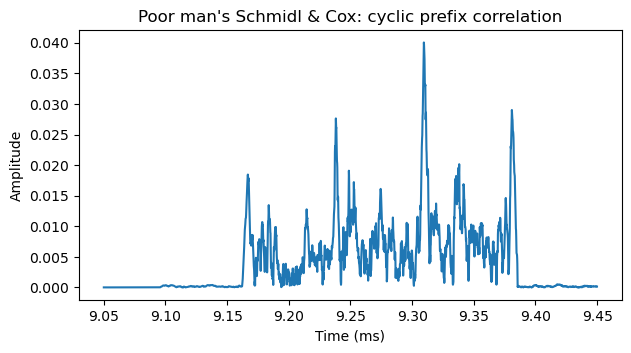

In [6]:
cp_corr = np.zeros(round(fs * 0.4e-3), 'complex')
corr_start = round(9.05e-3 * fs)
for j in range(cp_corr.size):
    y = x[corr_start + j:][:Ncp+Tu]
    cp_corr[j] = np.sum(y[:Ncp] * np.conjugate(y[-Ncp:]))

t_corr = 1e3 * (np.arange(cp_corr.size) + corr_start) / fs
plt.plot(t_corr, np.abs(cp_corr))
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title("Poor man's Schmidl & Cox: cyclic prefix correlation");

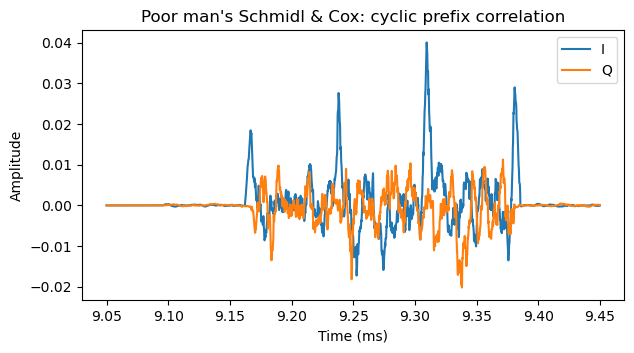

In [7]:
plt.plot(t_corr, np.real(cp_corr))
plt.plot(t_corr, np.imag(cp_corr))
plt.legend(['I', 'Q'])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title("Poor man's Schmidl & Cox: cyclic prefix correlation");

In [8]:
m0 = np.argmax(np.abs(cp_corr[:1000]))
m1 = np.argmax(np.abs(cp_corr[1000:1500])) + 1000
m2 = np.argmax(np.abs(cp_corr[1500:2250])) + 1500
m3 = np.argmax(np.abs(cp_corr[2250:])) + 2250

In [9]:
# CFO estimates (Hz)
-np.angle(cp_corr[[m0, m1, m2, m3]]) / (2 * np.pi) * (fs / Tu)

array([42.16427058, -6.20543153,  5.5234669 , 42.04846527])

## PSS demodulation

In [10]:
# start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a0 = corr_start + m0 + Ncp // 2

f = np.fft.fftshift(np.fft.fft(x[a0:a0+Tu]))
# correct for the 5G NR upconversion discontinuity
# this PSS is transmitted on symbol 2 mod 7
f *= phase_corr[2]
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)

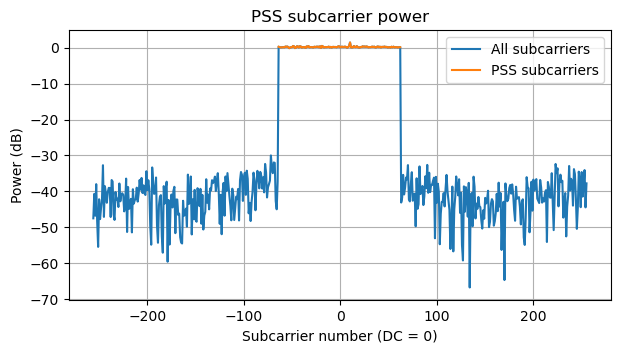

In [11]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). By chance, the SS/PBCH block is
# centred with respect to this choice of DC.
pss_sc_sel = range(Tu//2-120+56, Tu//2-120+56+127)
plt.plot(np.arange(f.size) - Tu//2, 10*np.log10(np.abs(f)**2))
plt.plot(np.arange(f.size)[pss_sc_sel] - Tu//2, 10*np.log10(np.abs(f[pss_sc_sel])**2))
pss_sym_demod = f[pss_sc_sel]
plt.title('PSS subcarrier power')
plt.xlabel('Subcarrier number (DC = 0)')
plt.ylabel('Power (dB)')
plt.legend(['All subcarriers', 'PSS subcarriers'])
plt.grid();

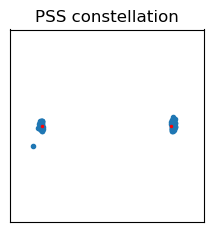

In [12]:
constellation_plot(pss_sym_demod, 'PSS constellation')

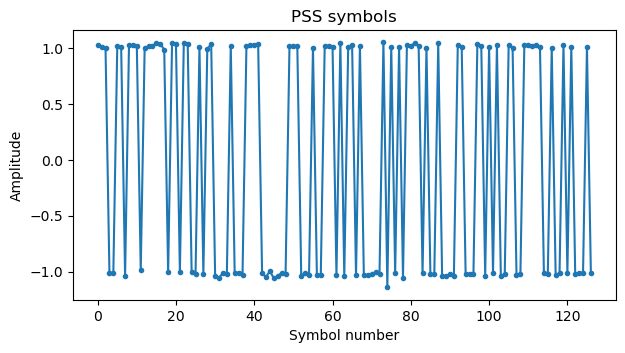

In [13]:
plt.plot(pss_sym_demod.real, '.-')
plt.title('PSS symbols')
plt.xlabel('Symbol number')
plt.ylabel('Amplitude');

In [14]:
def pss_sequence(nid2):
    x = np.zeros(127, 'uint8')
    x[:7] = [1, 1, 1, 0, 1, 1, 0][::-1]
    for j in range(127 - 7):
        x[j + 7] = x[j + 4] ^ x[j]
    return 1 - 2 * x[(np.arange(127) + 43 * nid2) % 127].astype('float')

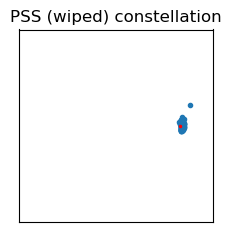

In [15]:
pss_sym_demod_wipe = pss_sym_demod * pss_sequence(1)

constellation_plot(pss_sym_demod_wipe, 'PSS (wiped) constellation', ref='pilot')

In [16]:
# phase error
np.angle(np.average(pss_sym_demod_wipe))

np.float64(0.0026920108363745116)

## PSS time domain correlation

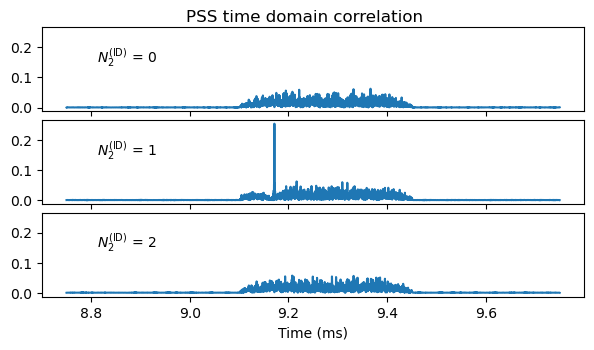

In [17]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

for nid2 in range(3):
    pss_re = np.zeros(Tu, 'complex')
    pss_re[pss_sc_sel] = pss_sequence(nid2)
    pss_sym = np.fft.ifft(np.fft.fftshift(pss_re))
    pss_corr = np.zeros(round(fs * 1e-3), 'complex')
    time_corr_start = round(8.75e-3 * fs)
    for j in range(pss_corr.size):
        pss_corr[j] = np.sum(x[time_corr_start + j:][:Tu] * np.conjugate(pss_sym))
    tcorr = 1e3*(time_corr_start + np.arange(pss_corr.size))/fs
    axs[nid2].plot(tcorr, np.abs(pss_corr))
    axs[nid2].text(tcorr[pss_corr.size//16], 0.15, f'$N^{{\\mathrm{{(ID)}}}}_2$ = {nid2}')

plt.subplots_adjust(hspace=0.1)
plt.suptitle('PSS time domain correlation', y=0.93)
axs[-1].set_xlabel('Time (ms)');

In [18]:
NID2 = 1

## SSS demodulation

In [19]:
def sss_sequence(nid1, nid2, only_x1=False, no_x1=False):
    x0 = np.zeros(127, 'uint8')
    x1 = np.zeros(127, 'uint8')
    x0[0] = 1
    x1[0] = 1
    for j in range(127 - 7):
        x0[j + 7] = x0[j + 4] ^ x0[j]
        x1[j + 7] = x1[j + 1] ^ x1[j]
    if only_x1:
        return 1 - 2 * x1.astype('float')
    m0 = 15 * (nid1 // 112) + 5 * nid2
    m1 = nid1 % 112
    if no_x1:
        return 1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')
    return ((1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')) *
            (1 - 2 * x1[(np.arange(127) + m1) % 127].astype('float')))

In [20]:
f = np.fft.fftshift(np.fft.fft(x[a0+2*(Ncp + Tu):][:Tu]))
# correct for the 5G NR upconversion discontinuity
# this SSS is transmitted in symbol 4 mod 7
f *= phase_corr[4]
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
sss_sym_demod = f[pss_sc_sel]

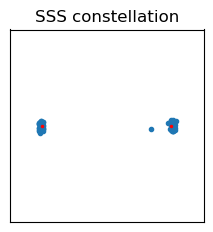

In [21]:
constellation_plot(sss_sym_demod, 'SSS constellation')

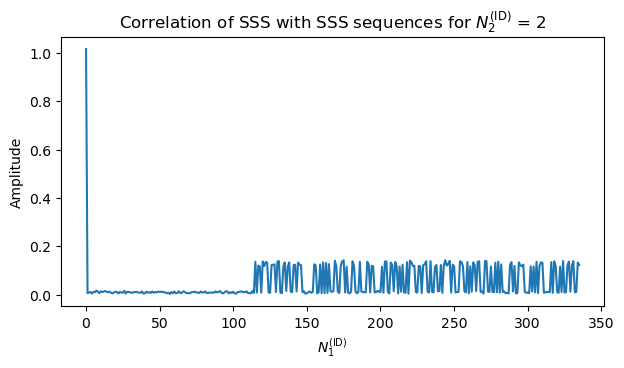

In [22]:
sss_corrs = np.empty(336, 'complex')
for j in range(sss_corrs.size):
    sss_corrs[j] = np.average(sss_sym_demod * sss_sequence(j, NID2))
plt.plot(np.abs(sss_corrs))
plt.title(f'Correlation of SSS with SSS sequences for $N^{{\\mathrm{{(ID)}}}}_2$ = {nid2}')
plt.xlabel('$N^{{\\mathrm{{(ID)}}}}_1$')
plt.ylabel('Amplitude');

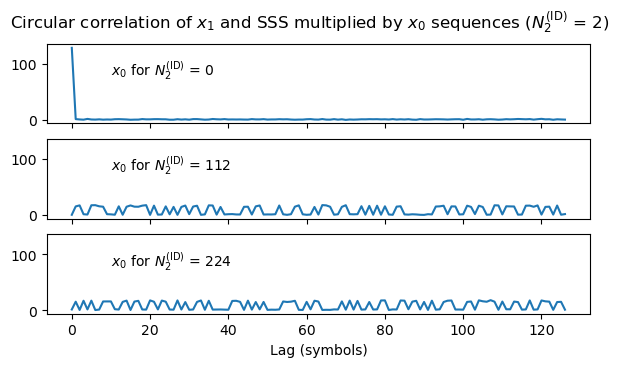

In [23]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
f_x1 = np.fft.fft(sss_sequence(0, 0, only_x1=True))
for j in range(3):
    f_sss_demod = np.fft.fft(sss_sym_demod * sss_sequence(j * 112, NID2, no_x1=True))
    corr_sss = np.fft.ifft(f_sss_demod * np.conjugate(f_x1))
    axs[j].plot(np.abs(corr_sss))
    axs[j].text(10, 80, f'$x_0$ for $N^{{\\mathrm{{(ID)}}}}_2$ = {j * 112}')
plt.suptitle(f'Circular correlation of $x_1$ and SSS multiplied by $x_0$ sequences ($N^{{\\mathrm{{(ID)}}}}_2$ = {nid2})')
axs[-1].set_xlabel('Lag (symbols)');

In [24]:
NID1 = 0
NcellID = 3 * NID1 + NID2
NcellID

1

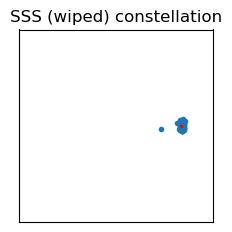

In [25]:
sss_sym_demod_wipe = sss_sym_demod * sss_sequence(NID1, NID2)

constellation_plot(sss_sym_demod_wipe, 'SSS (wiped) constellation', ref='pilot')

In [26]:
# CFO error (Hz) using PSS and SSS
((np.angle(np.average(sss_sym_demod_wipe)) - np.angle(np.average(pss_sym_demod_wipe))) / (2*np.pi) 
 * fs / (2 * (Tu + Ncp)))

np.float64(-2.2820508867164304)

## OFDM demodulation

In [27]:
Nsymbols = int((x.size - a0) / (1e-3 * fs) * 14)
symbols = np.empty((Nsymbols, Tu), 'complex')
t_symbols = np.empty(Nsymbols)
for j in range(Nsymbols):
    # Symbol index. Since we are starting at the PSS for j = 0,
    # which is symbol 2 mod 7, we need an offset of 2 here.
    symidx = j + 2
    off = a0 + j * (Ncp + Tu) + symidx // 7 * (Ncpl - Ncp)
    # correct for SFO
    off_err = (off - a0) * sfo + sto_fine * fs
    off_err_int = round(off_err)
    off_err_frac = off_err - off_err_int
    # Integer STO gets applied to the initial sample for OFDM demodulation
    # Fractional STO is applied as a phase slope after OFDM demodulation
    off_corr = off + off_err_int
    f = np.fft.fftshift(np.fft.fft(x[off_corr:off_corr+Tu]))
    # correct for the 5G NR upconversion discontinuity
    f *= phase_corr[symidx % 7]
    # correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
    # correct for fractional STO
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*off_err_frac)
    symbols[j] = f
    t_symbols[j] = (off_corr + off_err_frac + Ncp/2) / fs

## Constellation plots

In [28]:
# PBCH DMRS sequence
issb = 0
pbch_dmrs_seq = c_seq(2**11*(issb+1)*(NcellID//4 + 1) + 2**6*(issb+1) + (NcellID % 4), 288)
pbch_dmrs_seq = 1/np.sqrt(2) * ((1 - 2*pbch_dmrs_seq[::2].astype('float'))
                                + 1j * (1 - 2*pbch_dmrs_seq[1::2].astype('float')))

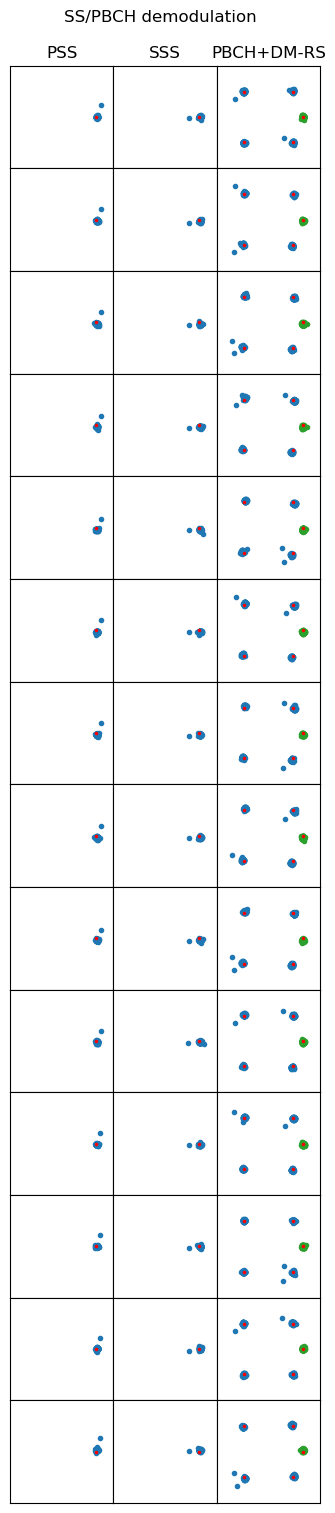

In [29]:
Nssblocks = Nsymbols // 140 + 1
plot_width = 4
fig, axs = plt.subplots(Nssblocks, 3, figsize=(plot_width, plot_width*Nssblocks/3))
pbchs = []
for j in range(Nssblocks):
    s0 = j * 140
    pss = symbols[s0, pss_sc_sel] * pss_sequence(NID2)
    sss = symbols[s0 + 2, pss_sc_sel] * sss_sequence(NID1, NID2)
    pbch = np.concatenate([
        symbols[s0 + 1, Tu//2-120:Tu//2+120],
        symbols[s0 + 2, Tu//2-120:Tu//2-120+48],
        symbols[s0 + 2, Tu//2-120+192:Tu//2+120],
        symbols[s0 + 3, Tu//2-120:Tu//2+120],
    ])
    pbch_dmrs = pbch[NcellID % 4::4]
    pbch_dmrs_wipe = pbch_dmrs * np.conjugate(pbch_dmrs_seq)
    pbch_data = pbch[(np.arange(pbch.size) % 4) != (NcellID % 4)]
    pbchs.append(pbch_data)
    constellation_plot(pss, ax=axs[j, 0], ref='pilot')
    constellation_plot(sss, ax=axs[j, 1], ref='pilot')
    constellation_plot(pbch_data, ax=axs[j, 2], ref='qpsk')
    constellation_plot(pbch_dmrs_wipe, ax=axs[j, 2], ref='pilot', color='C2')
pbchs = np.array(pbchs)
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('SS/PBCH demodulation', y=0.91)
axs[0, 0].set_title('PSS');
axs[0, 1].set_title('SSS');
axs[0, 2].set_title('PBCH+DM-RS');

In [30]:
flo_ss = f_center + (pss_sc_sel[0] - Tu//2 - 0.5) * 15e3 + cfo
fhi_ss = f_center + (pss_sc_sel[-1] - Tu//2 + 0.5) * 15e3 + cfo
flo_pbch = f_center - 120.5 * 15e3 + cfo
fhi_pbch = f_center + 120.5 * 15e3 + cfo
for j in range(Nssblocks):
    s0 = j * 140
    frame_start = round(t_symbols[s0] * fs - Ncp - 2 * Tu - Ncp - Ncpl)
    dataset.add_annotation(frame_start, min(int(10e-3 * fs), x.size - frame_start), metadata = {
        # some large frequency bounds that look nice and do not collide with other annotations
        SigMFFile.FLO_KEY: f_center - 3/8 * fs,
        SigMFFile.FHI_KEY: f_center + 3/8 * fs,
        SigMFFile.LABEL_KEY: f'Frame {j}',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })
    dataset.add_annotation(round(t_symbols[s0] * fs - Ncp), Tu + Ncp, metadata = {
        SigMFFile.FLO_KEY: flo_ss,
        SigMFFile.FHI_KEY: fhi_ss,
        SigMFFile.LABEL_KEY: 'PSS',
        SigMFFile.COMMENT_KEY: f'NID1 = {NID1}',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })
    dataset.add_annotation(round(t_symbols[s0 + 2] * fs - Ncp), Tu + Ncp, metadata = {
        SigMFFile.FLO_KEY: flo_ss,
        SigMFFile.FHI_KEY: fhi_ss,
        SigMFFile.LABEL_KEY: 'SSS',
        SigMFFile.COMMENT_KEY: f'NID1 = {NID1}\nNID2 = {NID2}\nNcellID = {NcellID}',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

In [31]:
# CFO error (Hz) using PSS symbols 120 ms apart
(np.angle(np.average(symbols[(Nssblocks-1)*140, pss_sc_sel] * pss_sequence(NID2))) 
 - np.angle(np.average(symbols[0, pss_sc_sel] * pss_sequence(NID2)))) / (2*np.pi*10e-3*Nssblocks)

np.float64(0.044393894958803234)

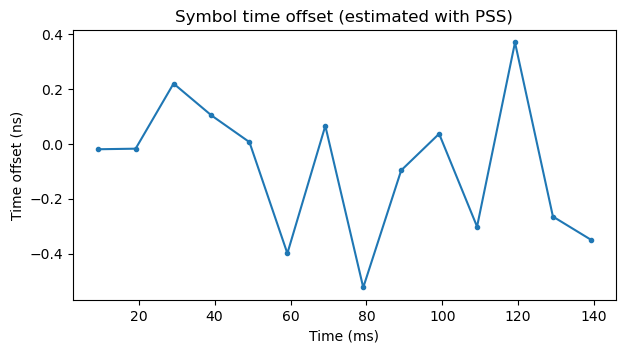

In [32]:
sto_pss_estimate = np.empty(Nssblocks)
for j in range(Nssblocks):
    sto_pss_estimate[j] = -np.polyfit(np.arange(127),
                                     np.angle(symbols[j*140, pss_sc_sel] * pss_sequence(NID2)), 1)[0] / (2 * np.pi) * Tu / fs
t_sto_pss_estimate = t_symbols[::140][:Nssblocks]
plt.plot(1e3 * t_sto_pss_estimate, 1e9 * sto_pss_estimate, '.-')
plt.title('Symbol time offset (estimated with PSS)')
plt.xlabel('Time (ms)')
plt.ylabel('Time offset (ns)');

In [33]:
# SFO (in parts per on) and initial STO estimates
np.polyfit(t_sto_pss_estimate, sto_pss_estimate, 1)

array([-1.76680744e-09,  4.79720392e-11])

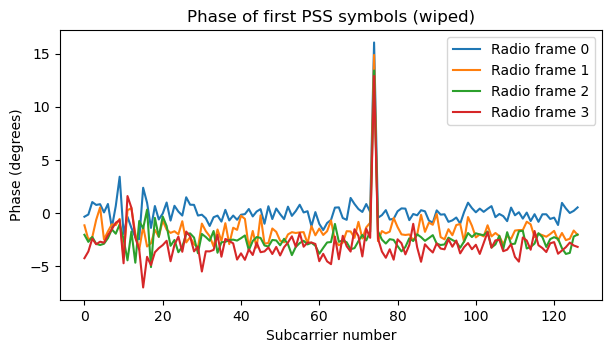

In [34]:
plt.plot(np.rad2deg(np.angle(symbols[:140*4:140, pss_sc_sel] * pss_sequence(NID2))).T)
plt.title('Phase of first PSS symbols (wiped)')
plt.xlabel('Subcarrier number')
plt.ylabel('Phase (degrees)')
plt.legend([f'Radio frame {n}' for n in range(4)]);

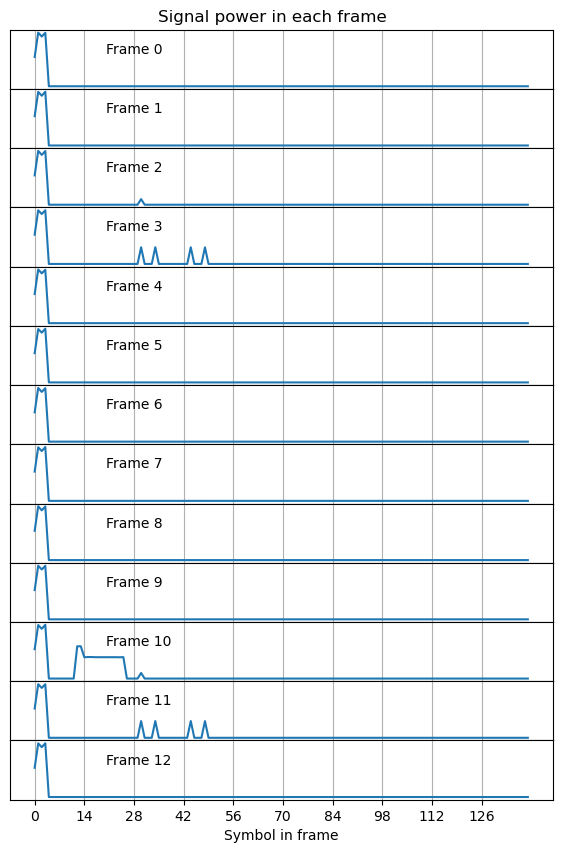

In [35]:
pwr_frame = np.sum(np.abs(symbols**2), axis=1)[:Nsymbols//140*140].reshape(-1, 140)
fig, axs = plt.subplots(13, figsize=(7, 10), sharex=True, sharey=True)
for j in range(pwr_frame.shape[0]):
    axs[j].plot(pwr_frame[j])
    axs[j].set_xticks(np.arange(0, 140, 14))
    axs[j].set_yticks([])
    axs[j].grid(axis='x')
    axs[j].text(20, 150, f'Frame {j}')
plt.subplots_adjust(hspace=0)
plt.suptitle('Signal power in each frame', y=0.90)
axs[-1].set_xlabel('Symbol in frame');

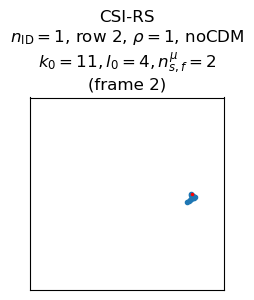

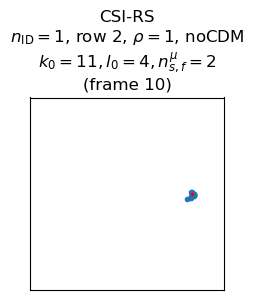

In [36]:
# CSI-RS

Nslotsymb = 14
ns = 2
l = 4
nID = 1

csi_rs_seq = c_seq(2**10*(Nslotsymb * ns + l + 1) * (2 * nID + 1) + nID, 25 * 2)
csi_rs_seq = 1/np.sqrt(2) * ((1 - 2*csi_rs_seq[::2].astype('float'))
                             + 1j * (1 - 2*csi_rs_seq[1::2].astype('float')))

for k in [2, 10]:
    s = symbols[k*140+30, 116:416][11::12] * np.conjugate(csi_rs_seq)
    constellation_plot(s, 'CSI-RS\n$n_{\\mathrm{ID}} = 1$, row 2, $\\rho = 1$, noCDM\n'
                       '$k_0 = 11, l_0 = 4, n_{s,f}^\\mu = 2$\n' + f'(frame {k})', ref='pilot')

In [37]:
for k in [2, 10]:
    j = k*140 + 30
    cplen = Ncpl if (j + 2) % 7 == 0 else Ncp
    dataset.add_annotation(round(t_symbols[j] * fs - cplen), Tu + cplen, metadata = {
        SigMFFile.FLO_KEY: f_center + (116 - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.FHI_KEY: f_center + (416 - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.LABEL_KEY: 'CSI-RS',
        SigMFFile.COMMENT_KEY: 'nID = 1, row 2, density 1, noCDM, k0 = 11, l0 = 4, ns = 2',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

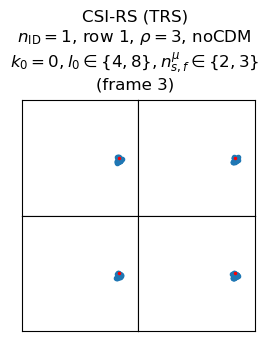

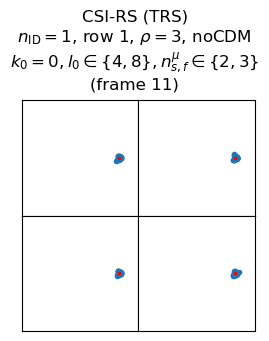

In [38]:
# TRS

for k in [3, 11]:
    s = symbols[k*140+30+np.array([0, 4, 14, 18]), 116:416:4]
    fig, axs = plt.subplots(2, 2, figsize=(3, 3))
    axs = axs.ravel()
    for j in range(s.shape[0]):
        ns = 2 if j // 2 == 0 else 3
        l = 4 if j % 2 == 0 else 8
        csi_rs_seq = c_seq(2**10*(Nslotsymb * ns + l + 1) * (2 * nID + 1) + nID, 75 * 2)
        csi_rs_seq = 1/np.sqrt(2) * ((1 - 2*csi_rs_seq[::2].astype('float'))
                                      + 1j * (1 - 2*csi_rs_seq[1::2].astype('float')))
        constellation_plot(s[j] * np.conjugate(csi_rs_seq), ax=axs[j], ref='pilot')
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle('CSI-RS (TRS)\n$n_{\\mathrm{ID}} = 1$, row 1, $\\rho = 3$, noCDM\n'
                 '$k_0 = 0, l_0 \\in \\{4, 8\\}, n_{s,f}^\\mu \\in \\{2, 3\\}$\n' + f'(frame {k})',
                 y=1.18)

In [39]:
for k in [3, 11]:
    for j in [0, 4, 14, 18]:
        k0 = k*140 + 30 + j
        cplen = Ncpl if (k0 + 2) % 7 == 0 else Ncp
        dataset.add_annotation(round(t_symbols[k0] * fs - cplen), Tu + cplen, metadata = {
            SigMFFile.FLO_KEY: f_center + (116 - Tu//2 - 0.5) * 15e3 + cfo,
            SigMFFile.FHI_KEY: f_center + (416 - Tu//2 - 0.5) * 15e3 + cfo,
            SigMFFile.LABEL_KEY: 'CSI-RS (TRS)',
            SigMFFile.COMMENT_KEY: f'nID = 1, row 1, density 3, noCDM, k0 = 0, l0 = {4 + j % 14}, ns = {2 + j // 14}',
            SigMFFile.GENERATOR_KEY: GENERATOR,
        })

In [40]:
np.where(np.abs(symbols[10*140+12+0, :]) > 0.6)

(array([164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
        216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379]),)

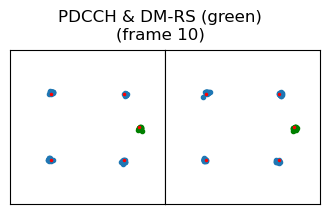

In [41]:
# PDCCH

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs = axs.ravel()

coresets = np.concatenate((np.arange(164, 236), np.arange(308, 380)))
# The PDCCH DMRS subcarrier indexing is referred to the beginning of the common RBs, not
# to the subcarrier within the coreset
common_rbs = np.arange(128, 416)
common_rbs_in_coresets = np.array([a in coresets for a in common_rbs])

for j in range(axs.size):
    s = symbols[10*140+12+j, common_rbs]
    pdcch_data = s[common_rbs_in_coresets]
    pdcch_data = pdcch_data[np.arange(pdcch_data.size) % 4 != 1]
    ns = 1
    l = j
    pdcch_dmrs_seq = c_seq(2**17*(Nslotsymb * ns + l + 1) * (2 * NcellID + 1) + 2*NcellID, s.size * 2 // 4)
    pdcch_dmrs_seq = 1/np.sqrt(2) * ((1 - 2*pdcch_dmrs_seq[::2].astype('float'))
                                      + 1j * (1 - 2*pdcch_dmrs_seq[1::2].astype('float')))
    pdcch_dmrs_wiped = (s[1::4] * np.conjugate(pdcch_dmrs_seq))[common_rbs_in_coresets[1::4]]
    constellation_plot(pdcch_data, ax=axs[j], ref='qpsk')
    constellation_plot(pdcch_dmrs_wiped, ax=axs[j], color='green', ref='pilot')
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDCCH & DM-RS (green)\n(frame 10)', y=1.08);

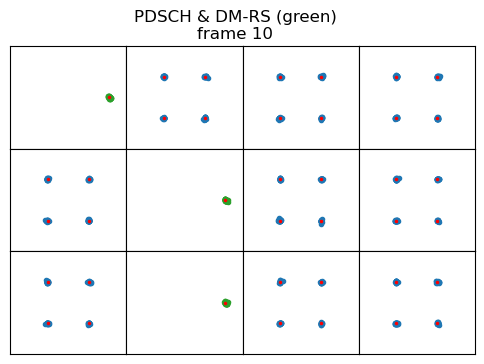

In [42]:
# PDSCH

s = symbols[10*140+14+np.arange(12), 128:224]
fig, axs = plt.subplots(3, 4, figsize=(6, 4))
axs = axs.ravel()
lim = 2
for j in range(s.shape[0]):
    if j in [0, 5, 9]:
        ns = 1
        l = j + 2
        dmrs_rs_seq = c_seq(2**17*(Nslotsymb * ns + l + 1) * (2 * NcellID + 1) + 2*NcellID, 48 * 2)
        dmrs_rs_seq = 1/np.sqrt(2) * ((1 - 2*dmrs_rs_seq[::2].astype('float'))
                                      + 1j * (1 - 2*dmrs_rs_seq[1::2].astype('float')))
        constellation_plot(s[j, ::2] * np.conjugate(dmrs_rs_seq), ax=axs[j],
                           refscale=np.sqrt(2), lim=lim, color='C2', ref='pilot')
    else:
        constellation_plot(s[j], ax=axs[j], lim=lim, ref='qpsk')
    plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDSCH & DM-RS (green)\nframe 10', y=0.97);

In [43]:
for j in [0, 5, 9]:
    k = 10*140+14+j
    cplen = Ncpl if (k + 2) % 7 == 0 else Ncp
    dataset.add_annotation(round(t_symbols[k] * fs - cplen), Tu + cplen, metadata = {
        SigMFFile.FLO_KEY: f_center + (128 - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.FHI_KEY: f_center + (224 - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.COMMENT_KEY: 'PDSCH DM-RS',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

## PBCH decoding

In [44]:
noise_sigma = 0.03 # standard deviation of noise in real (or imaginary) part only

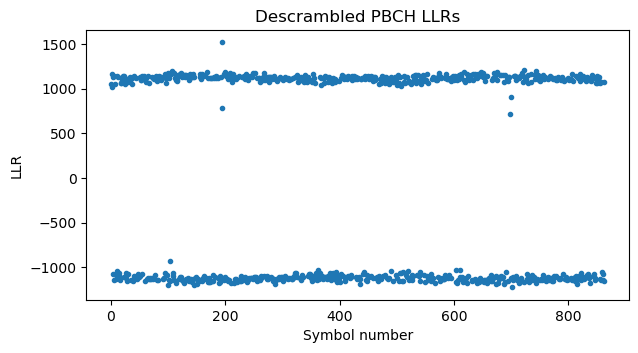

In [45]:
# here nu = 0
pbch_scrambling = 1 - 2 * c_seq(NcellID, 864).astype('float')
pbch_llrs = 2 * np.sqrt(0.5) / noise_sigma**2 * pbchs.view('float') * pbch_scrambling
plt.plot(pbch_llrs[0], '.')
plt.title('Descrambled PBCH LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

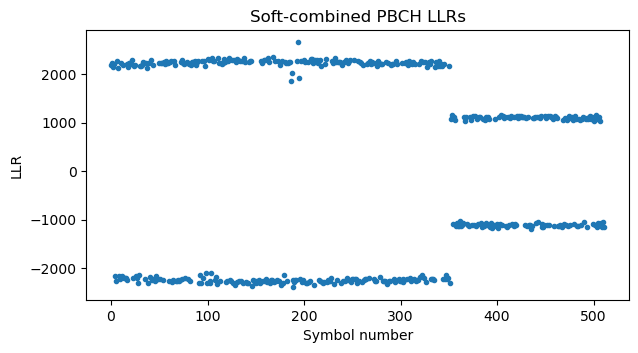

In [46]:
# undo rate-matching (repetition coding of the first 352 bits)
pbch_subinter = np.copy(pbch_llrs[:, :512])
pbch_subinter[:, :352] += pbch_llrs[:, 512:]
plt.plot(pbch_subinter[0], '.')
plt.title('Soft-combined PBCH LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

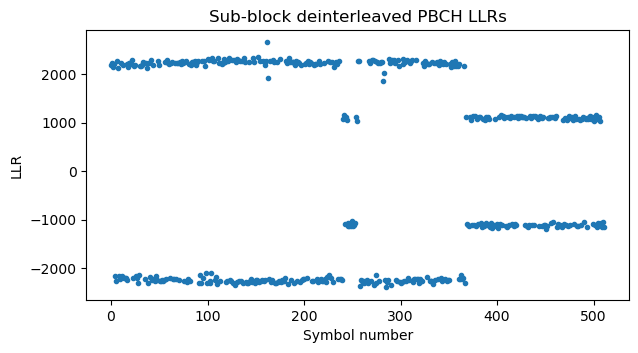

In [47]:
# undo sub-block interleaving
def subblock_deinterleave(llrs):
    sub_block_interleaver = [0, 1, 2, 4, 3, 5, 6, 7, 8, 16, 9, 17, 10, 18, 11, 19,
                             12, 20, 13, 21, 14, 22, 15, 23, 24, 25, 26, 28, 27, 29, 30, 31]
    sub_block_interleaver_inv = [sub_block_interleaver.index(n) for n in range(32)]
    N = llrs.shape[-1]
    return llrs.reshape(-1, 32, N // 32)[:, sub_block_interleaver_inv, :].reshape(-1, N)

pbch_polar = subblock_deinterleave(pbch_subinter)
plt.plot(pbch_polar[0], '.')
plt.title('Sub-block deinterleaved PBCH LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

In [48]:
# crude polar decoding assuming no bit errors
pbch_polar_hard = (pbch_polar < 0).astype('uint8')
for s in range(8, -1, -1):
    a = pbch_polar_hard.reshape(-1, 512//2**s, 2**s)
    a[:, ::2] ^= a[:, 1::2]

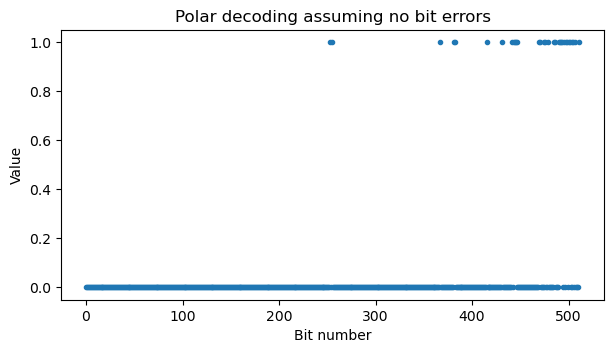

In [49]:
plt.plot(pbch_polar_hard[0], '.')
plt.title('Polar decoding assuming no bit errors')
plt.xlabel('Bit number')
plt.ylabel('Value');

In [50]:
polar_reliability_list = np.array([
    0, 1, 2, 4, 8, 16, 32, 3, 5, 64, 9, 6, 17, 10, 18, 128, 12, 33, 65, 20, 256, 34, 24, 36, 7, 129, 66, 512,
    11, 40, 68, 130, 19, 13, 48, 14, 72, 257, 21, 132, 35, 258, 26, 513, 80, 37, 25, 22, 136, 260, 264, 38,
    514, 96, 67, 41, 144, 28, 69, 42, 516, 49, 74, 272, 160, 520, 288, 528, 192, 544, 70, 44, 131, 81, 50, 73,
    15, 320, 133, 52, 23, 134, 384, 76, 137, 82, 56, 27, 97, 39, 259, 84, 138, 145, 261, 29, 43, 98, 515, 88,
    140, 30, 146, 71, 262, 265, 161, 576, 45, 100, 640, 51, 148, 46, 75, 266, 273, 517, 104, 162, 53, 193, 152,
    77, 164, 768, 268, 274, 518, 54, 83, 57, 521, 112, 135, 78, 289, 194, 85, 276, 522, 58, 168, 139, 99, 86,
    60, 280, 89, 290, 529, 524, 196, 141, 101, 147, 176, 142, 530, 321, 31, 200, 90, 545, 292, 322, 532, 263,
    149, 102, 105, 304, 296, 163, 92, 47, 267, 385, 546, 324, 208, 386, 150, 153, 165, 106, 55, 328, 536, 577,
    548, 113, 154, 79, 269, 108, 578, 224, 166, 519, 552, 195, 270, 641, 523, 275, 580, 291, 59, 169, 560, 114,
    277, 156, 87, 197, 116, 170, 61, 531, 525, 642, 281, 278, 526, 177, 293, 388, 91, 584, 769, 198, 172, 120,
    201, 336, 62, 282, 143, 103, 178, 294, 93, 644, 202, 592, 323, 392, 297, 770, 107, 180, 151, 209, 284, 648,
    94, 204, 298, 400, 608, 352, 325, 533, 155, 210, 305, 547, 300, 109, 184, 534, 537, 115, 167, 225, 326, 306,
    772, 157, 656, 329, 110, 117, 212, 171, 776, 330, 226, 549, 538, 387, 308, 216, 416, 271, 279, 158, 337, 550,
    672, 118, 332, 579, 540, 389, 173, 121, 553, 199, 784, 179, 228, 338, 312, 704, 390, 174, 554, 581, 393, 283,
    122, 448, 353, 561, 203, 63, 340, 394, 527, 582, 556, 181, 295, 285, 232, 124, 205, 182, 643, 562, 286, 585,
    299, 354, 211, 401, 185, 396, 344, 586, 645, 593, 535, 240, 206, 95, 327, 564, 800, 402, 356, 307, 301, 417,
    213, 568, 832, 588, 186, 646, 404, 227, 896, 594, 418, 302, 649, 771, 360, 539, 111, 331, 214, 309, 188, 449,
    217, 408, 609, 596, 551, 650, 229, 159, 420, 310, 541, 773, 610, 657, 333, 119, 600, 339, 218, 368, 652, 230,
    391, 313, 450, 542, 334, 233, 555, 774, 175, 123, 658, 612, 341, 777, 220, 314, 424, 395, 673, 583, 355, 287,
    183, 234, 125, 557, 660, 616, 342, 316, 241, 778, 563, 345, 452, 397, 403, 207, 674, 558, 785, 432, 357, 187,
    236, 664, 624, 587, 780, 705, 126, 242, 565, 398, 346, 456, 358, 405, 303, 569, 244, 595, 189, 566, 676, 361,
    706, 589, 215, 786, 647, 348, 419, 406, 464, 680, 801, 362, 590, 409, 570, 788, 597, 572, 219, 311, 708, 598,
    601, 651, 421, 792, 802, 611, 602, 410, 231, 688, 653, 248, 369, 190, 364, 654, 659, 335, 480, 315, 221, 370,
    613, 422, 425, 451, 614, 543, 235, 412, 343, 372, 775, 317, 222, 426, 453, 237, 559, 833, 804, 712, 834, 661,
    808, 779, 617, 604, 433, 720, 816, 836, 347, 897, 243, 662, 454, 318, 675, 618, 898, 781, 376, 428, 665, 736,
    567, 840, 625, 238, 359, 457, 399, 787, 591, 678, 434, 677, 349, 245, 458, 666, 620, 363, 127, 191, 782, 407,
    436, 626, 571, 465, 681, 246, 707, 350, 599, 668, 790, 460, 249, 682, 573, 411, 803, 789, 709, 365, 440, 628,
    689, 374, 423, 466, 793, 250, 371, 481, 574, 413, 603, 366, 468, 655, 900, 805, 615, 684, 710, 429, 794, 252,
    373, 605, 848, 690, 713, 632, 482, 806, 427, 904, 414, 223, 663, 692, 835, 619, 472, 455, 796, 809, 714, 721,
    837, 716, 864, 810, 606, 912, 722, 696, 377, 435, 817, 319, 621, 812, 484, 430, 838, 667, 488, 239, 378, 459,
    622, 627, 437, 380, 818, 461, 496, 669, 679, 724, 841, 629, 351, 467, 438, 737, 251, 462, 442, 441, 469, 247,
    683, 842, 738, 899, 670, 783, 849, 820, 728, 928, 791, 367, 901, 630, 685, 844, 633, 711, 253, 691, 824, 902,
    686, 740, 850, 375, 444, 470, 483, 415, 485, 905, 795, 473, 634, 744, 852, 960, 865, 693, 797, 906, 715, 807,
    474, 636, 694, 254, 717, 575, 913, 798, 811, 379, 697, 431, 607, 489, 866, 723, 486, 908, 718, 813, 476, 856,
    839, 725, 698, 914, 752, 868, 819, 814, 439, 929, 490, 623, 671, 739, 916, 463, 843, 381, 497, 930, 821, 726,
    961, 872, 492, 631, 729, 700, 443, 741, 845, 920, 382, 822, 851, 730, 498, 880, 742, 445, 471, 635, 932, 687,
    903, 825, 500, 846, 745, 826, 732, 446, 962, 936, 475, 853, 867, 637, 907, 487, 695, 746, 828, 753, 854, 857,
    504, 799, 255, 964, 909, 719, 477, 915, 638, 748, 944, 869, 491, 699, 754, 858, 478, 968, 383, 910, 815, 976,
    870, 917, 727, 493, 873, 701, 931, 756, 860, 499, 731, 823, 922, 874, 918, 502, 933, 743, 760, 881, 494, 702,
    921, 501, 876, 847, 992, 447, 733, 827, 934, 882, 937, 963, 747, 505, 855, 924, 734, 829, 965, 938, 884, 506,
    749, 945, 966, 755, 859, 940, 830, 911, 871, 639, 888, 479, 946, 750, 969, 508, 861, 757, 970, 919, 875, 862,
    758, 948, 977, 923, 972, 761, 877, 952, 495, 703, 935, 978, 883, 762, 503, 925, 878, 735, 993, 885, 939, 994,
    980, 926, 764, 941, 967, 886, 831, 947, 507, 889, 984, 751, 942, 996, 971, 890, 509, 949, 973, 1000, 892, 950,
    863, 759, 1008, 510, 979, 953, 763, 974, 954, 879, 981, 982, 927, 995, 765, 956, 887, 985, 997, 986, 943, 891,
    998, 766, 511, 988, 1001, 951, 1002, 893, 975, 894, 1009, 955, 1004, 1010, 957, 983, 958, 987, 1012, 999, 1016,
    767, 989, 1003, 990, 1005, 959, 1011, 1013, 895, 1006, 1014, 1017, 1018, 991, 1020, 1007, 1015, 1019, 1021,
    1022, 1023])

def calc_frozen_bits(K, *, n=9, puncturing=0):
    frozen_bits = polar_reliability_list[polar_reliability_list < 2**n][:-K]
    if puncturing != 0:
        # check that bits that are forced to be frozen by rate matching
        # are indeed frozen by the choice above
        N = 2**n
        E = N - puncturing
        M = 3 * N / 4 - E / 2 if E >= 3 * N / 4 else 9 * N / 16 - E / 4
        M = int(np.ceil(M))
        for n in range(M):
            assert n in frozen_bits
        punctured = np.concatenate((np.ones(puncturing, dtype='bool'), np.zeros(E, dtype='bool')))
        punctured = subblock_deinterleave(np.array(punctured))[0]
        for n in np.where(punctured)[0]:
            assert n in frozen_bits        
    return frozen_bits

In [51]:
pbch_info_bits = 32
pbch_crc_len = 24
pbch_tb_len = pbch_info_bits + pbch_crc_len
frozen_bits = calc_frozen_bits(pbch_tb_len)
assert np.all(pbch_polar_hard[:, frozen_bits] == 0)

In [52]:
# SC LLR decoding (Ref: II.B in https://arxiv.org/pdf/2007.11394)
def minstar(x, y):
    xx = np.abs(x)
    yy = np.abs(y)
    s = np.sign(x) * np.sign(y)
    return s * (np.fmin(xx, yy) - np.log1p(np.exp(-np.abs(xx - yy))) + np.log1p(np.exp(-(xx + yy))))

def sc_decoder_process(j, idxs, alphas, frozen_bits):
    if j == 0:
        hard_decision = 1 * (alphas[:, 0, idxs] < 0)
        # force frozen bits to zero
        if idxs[0] in frozen_bits:
            alphas[:, 0, idxs] = np.inf
            hard_decision *= 0
        return hard_decision
    left, right = idxs.reshape(2, -1)
    alphas[:, j - 1, left] = minstar(alphas[:, j, left], alphas[:, j, right])
    betas_left = sc_decoder_process(j - 1, left, alphas, frozen_bits)
    alphas[:, j - 1, right] = (
        (-1)**betas_left * alphas[:, j, left] + alphas[:, j, right])
    betas_right = sc_decoder_process(j - 1, right, alphas, frozen_bits)
    return np.concatenate((betas_left ^ betas_right, betas_right), axis=1)

def sc_decoder(llrs, K, *, n=9, puncturing=0):
    frozen_bits = calc_frozen_bits(K, n=n, puncturing=puncturing)
    assert llrs.shape[1] == 2**n
    alphas = np.zeros((llrs.shape[0], n + 1, 2**n))
    alphas[:, -1] = llrs
    sc_decoder_process(n, np.arange(2**n), alphas, frozen_bits)
    sc_decoder_out = 1 * (alphas[:, 0] < 0)
    msg = sc_decoder_out[:, sorted(polar_reliability_list[polar_reliability_list < 2**n][-K:])]
    return msg, sc_decoder_out, alphas

pbch_interleaved, sc_decoder_out, alphas = sc_decoder(pbch_polar, pbch_tb_len)

In [53]:
assert np.all(sc_decoder_out == pbch_polar_hard)

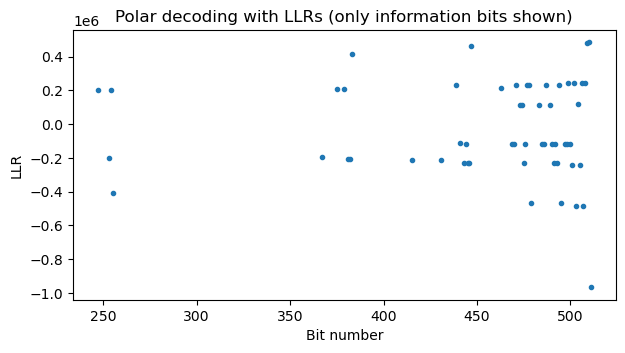

In [54]:
plt.plot(alphas[0, 0], '.')
plt.title('Polar decoding with LLRs (only information bits shown)')
plt.xlabel('Bit number')
plt.ylabel('LLR');

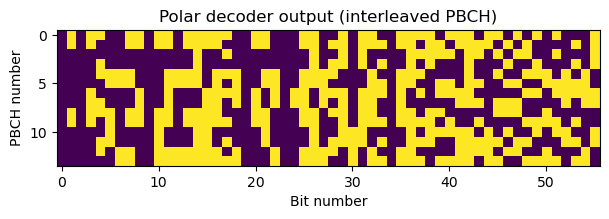

In [55]:
plt.imshow(pbch_interleaved)
plt.title('Polar decoder output (interleaved PBCH)')
plt.xlabel('Bit number')
plt.ylabel('PBCH number');

In [56]:
# undo interleaving
def polar_deinterleave(messages):
    interleaver_permuation = np.array([
         0, 2, 4, 7, 9, 14, 19, 20, 24, 25, 26, 28, 31, 34, 42, 45, 49, 50, 51, 53, 54, 56, 58, 59,
         61, 62, 65, 66, 67, 69, 70, 71, 72, 76, 77, 81, 82, 83, 87, 88, 89, 91, 93, 95, 98, 101,
         104, 106, 108, 110, 111, 113, 115, 118, 119, 120, 122, 123, 126, 127, 129, 132, 134, 138,
         139, 140, 1, 3, 5, 8, 10, 15, 21, 27, 29, 32, 35, 43, 46, 52, 55, 57, 60, 63, 68, 73, 78,
         84, 90, 92, 94, 96, 99, 102, 105, 107, 109, 112, 114, 116, 121, 124, 128, 130, 133, 135,
         141, 6, 11, 16, 22, 30, 33, 36, 44, 47, 64, 74, 79, 85, 97, 100, 103, 117, 125, 131, 136,
         142, 12, 17, 23, 37, 48, 75, 80, 86, 137, 143, 13, 18, 38, 144, 39, 145, 40, 146, 41, 147,
         148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163])
    K = messages.shape[-1]
    assert K <= 164
    interleaver_permuation_short = interleaver_permuation[interleaver_permuation >= 164 - K] - (164 - K)
    interleaver_permuation_short_inv = [list(interleaver_permuation_short).index(a) for a in range(len(interleaver_permuation_short))]
    return messages[..., interleaver_permuation_short_inv]

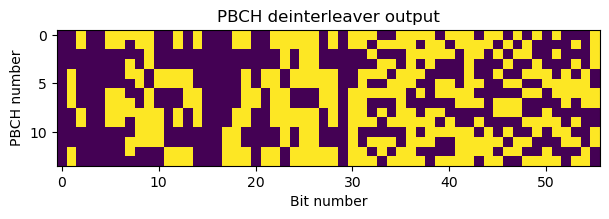

In [57]:
pbch_with_crc = polar_deinterleave(pbch_interleaved)
plt.imshow(pbch_with_crc)
plt.title('PBCH deinterleaver output')
plt.xlabel('Bit number')
plt.ylabel('PBCH number');

In [58]:
# pycrc --width 24 --poly 0xb2b117 --reflect-in false --reflect-out false --xor-in 0 --xor-out 0 --algorithm table-driven --generate c
crc24c_table = [
    0x000000, 0xb2b117, 0xd7d339, 0x65622e, 0x1d1765, 0xafa672, 0xcac45c, 0x78754b,
    0x3a2eca, 0x889fdd, 0xedfdf3, 0x5f4ce4, 0x2739af, 0x9588b8, 0xf0ea96, 0x425b81,
    0x745d94, 0xc6ec83, 0xa38ead, 0x113fba, 0x694af1, 0xdbfbe6, 0xbe99c8, 0x0c28df,
    0x4e735e, 0xfcc249, 0x99a067, 0x2b1170, 0x53643b, 0xe1d52c, 0x84b702, 0x360615,
    0xe8bb28, 0x5a0a3f, 0x3f6811, 0x8dd906, 0xf5ac4d, 0x471d5a, 0x227f74, 0x90ce63,
    0xd295e2, 0x6024f5, 0x0546db, 0xb7f7cc, 0xcf8287, 0x7d3390, 0x1851be, 0xaae0a9,
    0x9ce6bc, 0x2e57ab, 0x4b3585, 0xf98492, 0x81f1d9, 0x3340ce, 0x5622e0, 0xe493f7,
    0xa6c876, 0x147961, 0x711b4f, 0xc3aa58, 0xbbdf13, 0x096e04, 0x6c0c2a, 0xdebd3d,
    0x63c747, 0xd17650, 0xb4147e, 0x06a569, 0x7ed022, 0xcc6135, 0xa9031b, 0x1bb20c,
    0x59e98d, 0xeb589a, 0x8e3ab4, 0x3c8ba3, 0x44fee8, 0xf64fff, 0x932dd1, 0x219cc6,
    0x179ad3, 0xa52bc4, 0xc049ea, 0x72f8fd, 0x0a8db6, 0xb83ca1, 0xdd5e8f, 0x6fef98,
    0x2db419, 0x9f050e, 0xfa6720, 0x48d637, 0x30a37c, 0x82126b, 0xe77045, 0x55c152,
    0x8b7c6f, 0x39cd78, 0x5caf56, 0xee1e41, 0x966b0a, 0x24da1d, 0x41b833, 0xf30924,
    0xb152a5, 0x03e3b2, 0x66819c, 0xd4308b, 0xac45c0, 0x1ef4d7, 0x7b96f9, 0xc927ee,
    0xff21fb, 0x4d90ec, 0x28f2c2, 0x9a43d5, 0xe2369e, 0x508789, 0x35e5a7, 0x8754b0,
    0xc50f31, 0x77be26, 0x12dc08, 0xa06d1f, 0xd81854, 0x6aa943, 0x0fcb6d, 0xbd7a7a,
    0xc78e8e, 0x753f99, 0x105db7, 0xa2eca0, 0xda99eb, 0x6828fc, 0x0d4ad2, 0xbffbc5,
    0xfda044, 0x4f1153, 0x2a737d, 0x98c26a, 0xe0b721, 0x520636, 0x376418, 0x85d50f,
    0xb3d31a, 0x01620d, 0x640023, 0xd6b134, 0xaec47f, 0x1c7568, 0x791746, 0xcba651,
    0x89fdd0, 0x3b4cc7, 0x5e2ee9, 0xec9ffe, 0x94eab5, 0x265ba2, 0x43398c, 0xf1889b,
    0x2f35a6, 0x9d84b1, 0xf8e69f, 0x4a5788, 0x3222c3, 0x8093d4, 0xe5f1fa, 0x5740ed,
    0x151b6c, 0xa7aa7b, 0xc2c855, 0x707942, 0x080c09, 0xbabd1e, 0xdfdf30, 0x6d6e27,
    0x5b6832, 0xe9d925, 0x8cbb0b, 0x3e0a1c, 0x467f57, 0xf4ce40, 0x91ac6e, 0x231d79,
    0x6146f8, 0xd3f7ef, 0xb695c1, 0x0424d6, 0x7c519d, 0xcee08a, 0xab82a4, 0x1933b3,
    0xa449c9, 0x16f8de, 0x739af0, 0xc12be7, 0xb95eac, 0x0befbb, 0x6e8d95, 0xdc3c82,
    0x9e6703, 0x2cd614, 0x49b43a, 0xfb052d, 0x837066, 0x31c171, 0x54a35f, 0xe61248,
    0xd0145d, 0x62a54a, 0x07c764, 0xb57673, 0xcd0338, 0x7fb22f, 0x1ad001, 0xa86116,
    0xea3a97, 0x588b80, 0x3de9ae, 0x8f58b9, 0xf72df2, 0x459ce5, 0x20fecb, 0x924fdc,
    0x4cf2e1, 0xfe43f6, 0x9b21d8, 0x2990cf, 0x51e584, 0xe35493, 0x8636bd, 0x3487aa,
    0x76dc2b, 0xc46d3c, 0xa10f12, 0x13be05, 0x6bcb4e, 0xd97a59, 0xbc1877, 0x0ea960,
    0x38af75, 0x8a1e62, 0xef7c4c, 0x5dcd5b, 0x25b810, 0x970907, 0xf26b29, 0x40da3e,
    0x0281bf, 0xb030a8, 0xd55286, 0x67e391, 0x1f96da, 0xad27cd, 0xc845e3, 0x7af4f4
]

def crc24c(data):
    crc = 0
    for d in data:
        tbl_idx = ((crc >> 16) ^ d) & 0xff
        crc = (crc24c_table[tbl_idx] ^ (crc << 8)) & 0xffffff
    return crc & 0xffffff

In [59]:
assert all([crc24c(msg) == 0 for msg in np.packbits(pbch_with_crc, axis=1)])

In [60]:
pbch_M = 32 - 3 # Lmax = 4
pbch_scrambler_seqs = c_seq(NcellID, pbch_M * 4).reshape(4, -1)

In [61]:
pbch_G = np.array([16, 23, 18, 17, 8, 30, 10, 6, 24, 7, 0, 5, 3, 2, 1, 4, 9, 11, 12, 13, 14, 15, 19, 20, 21, 22, 25,
                   26, 27, 28, 29, 31])
sfn_32_pos = pbch_G[7:9]
half_frame_pos = pbch_G[10]
scrambled_pos = np.array([n for n in range(32) if n not in sfn_32_pos and n != half_frame_pos])
pbch_nu = np.packbits(pbch_with_crc[:, sfn_32_pos], axis=1).ravel() >> 6
pbch_nu

array([3, 3, 0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1], dtype=uint8)

In [62]:
pbch_with_crc[:, half_frame_pos]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

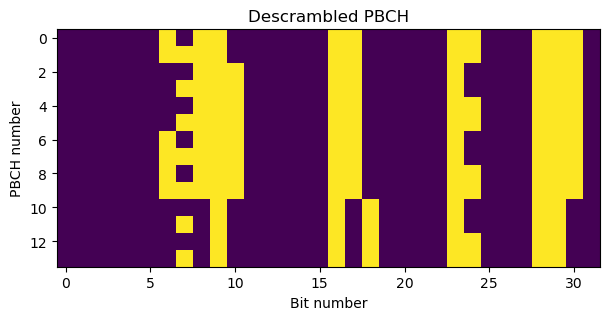

In [63]:
pbch_descrambled = np.copy(pbch_with_crc[:, :32])
for j in range(pbch_descrambled.shape[0]):
    pbch_descrambled[j, scrambled_pos] ^= pbch_scrambler_seqs[pbch_nu[j]]
plt.imshow(pbch_descrambled)
plt.title('Descrambled PBCH')
plt.xlabel('Bit number')
plt.ylabel('PBCH number');

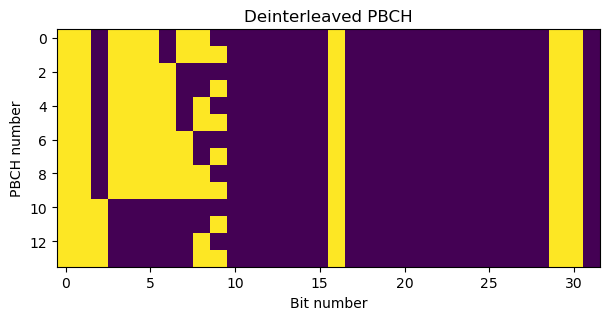

In [64]:
pbch_deinter = pbch_descrambled[:, pbch_G]
plt.imshow(pbch_deinter)
plt.title('Deinterleaved PBCH')
plt.xlabel('Bit number')
plt.ylabel('PBCH number');

In [65]:
pbch_sfn = np.sum(pbch_deinter[:, :10] * 2**np.arange(9, -1, -1), axis=1)
pbch_sfn

array([886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898,
       899])

In [66]:
pbch_ssb = pbch_deinter[:, 11:14]
pbch_ssb

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [67]:
bch_msg = np.packbits(pbch_deinter[:, np.concatenate(([14], np.arange(6), np.arange(15, 32)))], axis=1)

In [68]:
# ASN1 file downloaded from
# https://gitlab.eurecom.fr/oai/openairinterface5g/-/blob/develop/openair2/RRC/NR/MESSAGES/ASN.1/nr-rrc-17.3.0.asn1
#
# file modified to flatten everything under the namespace NR-RRC-Definitions
asn1_file = 'nr-rrc-17.3.0.asn1'

# hack parametrization support in asn1tools
# https://gist.github.com/bradleykohler96/3357811bf5b48ffeddda54255de7775b

def hackTemplatedType(memberDict: dict, templatedTypeDict: dict, name: str):
    """
    Hack the templated type by replacing it in memberDict.
    The final result is stored in memberDict["members"] and memberDict["type"].
    """
    asnType = memberDict["type"]

    if asnType != name:
        raise ValueError(f"Was expecting {name} but got {asnType} instead.")

    actualParameterList = deepcopy(memberDict["actual-parameters"])

    del memberDict["actual-parameters"]
    del memberDict["type"]

    memberList = deepcopy(templatedTypeDict["members"])
    parameterList = deepcopy(templatedTypeDict["parameters"])
    asnType = templatedTypeDict["type"]

    for actualParameter, parameter in zip(actualParameterList, parameterList):
        for member in memberList:
            if member["type"] == parameter:
                member["type"] = actualParameter["type"]

    memberDict["members"] = memberList
    memberDict["type"] = asnType


def hackTemplatedTypes(memberDict: dict, templatedTypeDict: dict, name: str):
    """
    Hack the templated type of all nested members of a type or member.
    This function is recursive.
    The name memberDict is misleading, it can actually be typeDict or memberDict.
    The final result is stored in each nested dictionary.
    """
    asnType = memberDict["type"]

    if asnType == name:
        hackTemplatedType(memberDict, templatedTypeDict, name)

    if "members" in memberDict:
        for member in memberDict["members"]:
            if member is None:
                continue  # this happens where there is three dots in the structure "..."

            if isinstance(member, dict):
                hackTemplatedTypes(member, templatedTypeDict, name)
            elif isinstance(member, list):
                for xgroupMember in member:
                    hackTemplatedTypes(xgroupMember, templatedTypeDict, name)
            else:
                memberType = type(member)
                raise TypeError(f"Expected member of type dict, list but got {memberType} instead.\n")


def modifyAsnDict(asnDict: dict):
    """
    Modify the dictionary for all nested members of all types.
    This function does the following:
    Hacks the templated type SetupRelease by replacing it in the dictionary.
    """
    for name, typeDict in asnDict["types"].items():
        # Hack the templated type SetupRelease.
        asnType = "SetupRelease"
        hackTemplatedTypes(typeDict, asnDict["types"][asnType], asnType)

    return asnDict


def compileFiles(filenames: Union[list, str],
                 codec: str = "ber",
                 encoding: str = "utf-8"):
    """
    A new compiler that supports SetupRelease.
    """
    # Parse the ASN text using ASN.1 tools.
    asnDict = asn1tools.parse_files(filenames, encoding=encoding)

    # Hack the templated type SetupRelease.
    modifyAsnDict(asnDict["NR-RRC-Definitions"])

    return asn1tools.compile_dict(asnDict, codec=codec)


asn1 = compileFiles(asn1_file, 'uper')

In [69]:
bch_decoded = [asn1.decode('BCCH-BCH-Message', bytes(b)) for b in bch_msg]
bch_decoded[0]

{'message': ('mib',
  {'systemFrameNumber': (b'\xdc', 6),
   'subCarrierSpacingCommon': 'scs15or60',
   'ssb-SubcarrierOffset': 8,
   'dmrs-TypeA-Position': 'pos2',
   'pdcch-ConfigSIB1': {'controlResourceSetZero': 0, 'searchSpaceZero': 0},
   'cellBarred': 'notBarred',
   'intraFreqReselection': 'notAllowed',
   'spare': (b'\x00', 1)})}

In [70]:
pprint.pp(bch_decoded[0])

{'message': ('mib',
             {'systemFrameNumber': (b'\xdc', 6),
              'subCarrierSpacingCommon': 'scs15or60',
              'ssb-SubcarrierOffset': 8,
              'dmrs-TypeA-Position': 'pos2',
              'pdcch-ConfigSIB1': {'controlResourceSetZero': 0,
                                   'searchSpaceZero': 0},
              'cellBarred': 'notBarred',
              'intraFreqReselection': 'notAllowed',
              'spare': (b'\x00', 1)})}


In [71]:
for j in range(Nssblocks):
    s0 = j * 140
    dataset.add_annotation(round(t_symbols[s0 + 1] * fs - Ncp), 3 * (Tu + Ncp), metadata = {
        SigMFFile.FLO_KEY: flo_pbch,
        SigMFFile.FHI_KEY: fhi_pbch,
        SigMFFile.LABEL_KEY: 'PBCH',
        SigMFFile.COMMENT_KEY:
            f'NcellID = {NcellID}\nIssb = {issb}\nSFN = {pbch_sfn[j]}'
            f'\nhalf-frame = {pbch_with_crc[j, half_frame_pos]}\n\nMIB\n{pprint.pformat(bch_decoded[j])}',
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

## PDCCH decoding

In [72]:
# TS 38.213 Table 13-1 (controlResourceSetZero = 0)
N_CORESET_RB = 24
N_CORESET_symb = 2

# TS 38.211 Section 7.3.2.2
L = 6
R = 2
n_shift = NcellID

N_CORESET_REG = N_CORESET_RB * N_CORESET_symb
C = N_CORESET_REG // (L * R)
r = np.arange(C * R) % R
c = np.arange(C * R) // R
f = (r * C + c + n_shift) % (N_CORESET_REG // L)
f

array([1, 5, 2, 6, 3, 7, 4, 0])

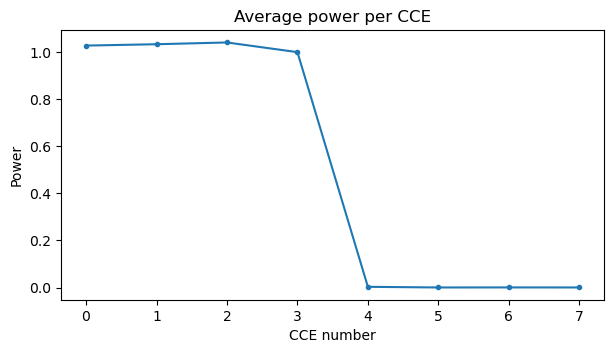

In [73]:
pdcch_sc_idx = np.arange(N_CORESET_RB * 12).reshape(N_CORESET_RB // (L // N_CORESET_symb), -1)[f]
pdcch_syms = symbols[10*140+12:, common_rbs][:N_CORESET_symb]
plt.plot(np.average(np.abs(pdcch_syms[:, pdcch_sc_idx])**2, axis=(0, 2)), '.-')
plt.title('Average power per CCE')
plt.xlabel('CCE number')
plt.ylabel('Power');

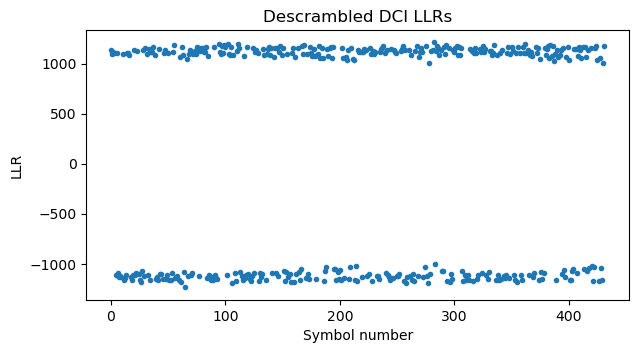

In [74]:
dci_symbols = pdcch_syms[:, np.sort(pdcch_sc_idx[:4].ravel())]
dci_symbols = dci_symbols[:, np.arange(dci_symbols.shape[1]) % 4 != 1].ravel()
dci_scrambling = 1 - 2 * c_seq(NcellID, 2 * dci_symbols.size).astype('float')
dci_llrs = 2 * np.sqrt(0.5) / noise_sigma**2 * dci_symbols.view('float') * dci_scrambling
plt.plot(dci_llrs, '.')
plt.title('Descrambled DCI LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

In [75]:
# calculations for Polar code parameters
K = 37 + 24
E = 432
n1 = int(np.ceil(np.log2(E)))
Rmin = 1/8
n2 = int(np.ceil(K/Rmin))
nmin = 5
nmax = 9
n = max(min(n1, n2, nmax), nmin)
n, K/E, 7/16

(9, 0.1412037037037037, 0.4375)

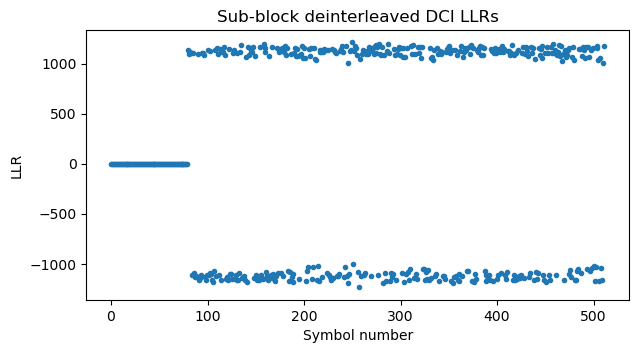

In [76]:
dci_llrs_ext = np.zeros(512)
# de-puncturing
dci_llrs_ext[-dci_llrs.size:] = dci_llrs
dci_polar = subblock_deinterleave(np.array([dci_llrs_ext]))
plt.plot(dci_polar[0], '.')
plt.title('Sub-block deinterleaved DCI LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

In [77]:
dci_info_bits = 37
dci_crc_len = 24
dci_tb_len = dci_info_bits + dci_crc_len
dci_interleaved, _, alphas = sc_decoder(dci_polar, dci_tb_len, puncturing=512-dci_llrs.size)
dci_with_crc = polar_deinterleave(dci_interleaved)[0]

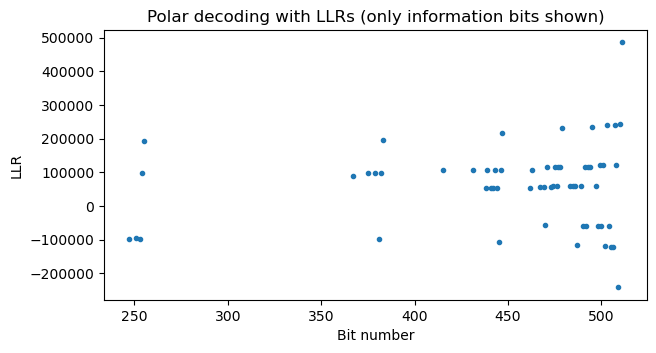

In [78]:
plt.plot(alphas[0, 0], '.')
plt.title('Polar decoding with LLRs (only information bits shown)')
plt.xlabel('Bit number')
plt.ylabel('LLR');

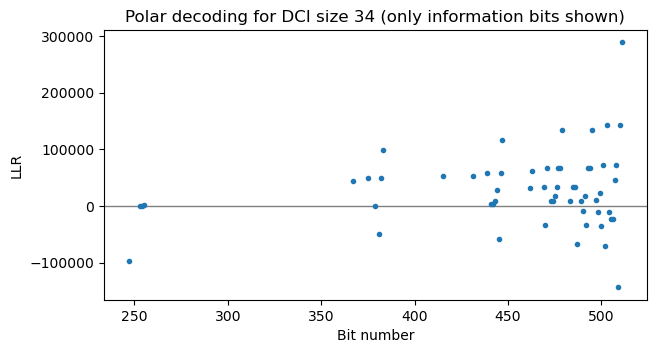

In [79]:
_, _, alphas_bad = sc_decoder(dci_polar, 34 + 24, puncturing=512-dci_llrs.size)
plt.axhline(y=0, color='grey', linewidth=1)
plt.plot(alphas_bad[0, 0], '.')
plt.title('Polar decoding for DCI size 34 (only information bits shown)')
plt.xlabel('Bit number')
plt.ylabel('LLR');

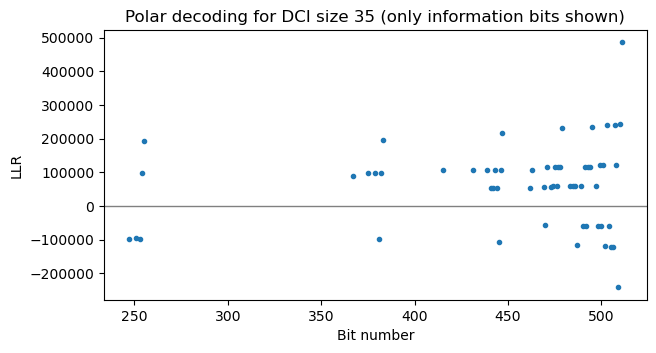

In [80]:
_, _, alphas_bad = sc_decoder(dci_polar, 35 + 24, puncturing=512-dci_llrs.size)
plt.axhline(y=0, color='grey', linewidth=1)
plt.plot(alphas_bad[0, 0], '.')
plt.title('Polar decoding for DCI size 35 (only information bits shown)')
plt.xlabel('Bit number')
plt.ylabel('LLR');

In [81]:
# pycrc --width 24 --poly 0xb2b117 --reflect-in false --reflect-out false --xor-in 0xffffff --xor-out 0 --algorithm bit-by-bit --generate c
def crc24c_bitwise(data, init=0):
    crc = init
    for d in data:
        b = crc & 0x800000
        crc = (crc << 1) | d
        if b:
            crc ^= 0xb2b117
        crc &= 0xffffff
    for _ in range(24):
        b = crc & 0x800000
        crc <<= 1
        if b:
            crc ^= 0xb2b117
        crc &= 0xffffff
    return crc

def check_dci_crc(dci, rnti):
    crc_calc = crc24c_bitwise(dci[:-24], init=0xffffff)
    crc_dci = np.sum(np.packbits(dci[-24:]).astype('int') * np.array([2**16, 2**8, 1]))
    return crc_calc ^ rnti == crc_dci

In [82]:
assert check_dci_crc(dci_with_crc, 0xffff)

In [83]:
# DCI format 1_0 parsing
ptr = 0
bits_freq_domain_assign = int(np.ceil(np.log2(N_CORESET_RB * (N_CORESET_RB + 1) / 2)))
freq_domain_assign = np.sum(dci_with_crc[ptr:][:bits_freq_domain_assign].astype('int') * 2**np.arange(bits_freq_domain_assign - 1, -1, -1))
ptr += bits_freq_domain_assign
print('freq_domain_assign =', freq_domain_assign)
time_domain_assign = np.sum(dci_with_crc[ptr:][:4].astype('int') * 2**np.arange(3, -1, -1))
ptr += 4
print('time_domain_assign =', time_domain_assign)
# TS 38 212 Table 7.3.1.2.2-5: VRB to PRB mapping = 0 -> non-interleaved
vrb_to_prb_mapping = dci_with_crc[ptr]
ptr += 1
print('vrb_to_prb_mapping =', vrb_to_prb_mapping)
mcs = np.sum(dci_with_crc[ptr:][:5].astype('int') * 2**np.arange(4, -1, -1))
ptr += 5
print('mcs =', mcs)
rv = np.sum(dci_with_crc[ptr:][:2].astype('int') * [2, 1])
ptr += 2
print('rv =', rv)
# TS 38 212 Table 7.3.1.2.1-2: system information indicator 0 = SIB1
system_information_indicator = dci_with_crc[ptr]
ptr += 1
print('system_information_indicator =', system_information_indicator)
rsvd = dci_with_crc[ptr:][:15]
assert np.all(rsvd == 0)
ptr += 15
print('rsvd =', rsvd)
assert ptr + 24 == len(dci_with_crc)

freq_domain_assign = 168
time_domain_assign = 0
vrb_to_prb_mapping = 0
mcs = 5
rv = 0
system_information_indicator = 0
rsvd = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [84]:
a = freq_domain_assign // N_CORESET_RB
b = freq_domain_assign % N_CORESET_RB
assert a + b + 1 <= N_CORESET_RB
RBstart = b
Lrbs = a + 1
RBstart, Lrbs

(np.int64(0), np.int64(8))

In [85]:
for blks in [(164, 236), (308, 380)]:
    dataset.add_annotation(round(t_symbols[10*140+12] * fs - Ncpl), 2 * Tu + Ncp + Ncpl, metadata = {
        SigMFFile.FLO_KEY: f_center + (blks[0] - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.FHI_KEY: f_center + (blks[1] - Tu//2 - 0.5) * 15e3 + cfo,
        SigMFFile.LABEL_KEY: 'PDCCH',
        SigMFFile.COMMENT_KEY: f"""DCI format 1_0 (aggregation level 4) SI-RNTI

Frequency domain assignment: first RB {RBstart}, number of RBs {Lrbs}
Time domain assignment: {time_domain_assign}
VRB to PRB mapping: {vrb_to_prb_mapping}
MCS: {mcs}
RV: {rv}
System information indicator: {system_information_indicator}""",
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

## PDSCH decoding

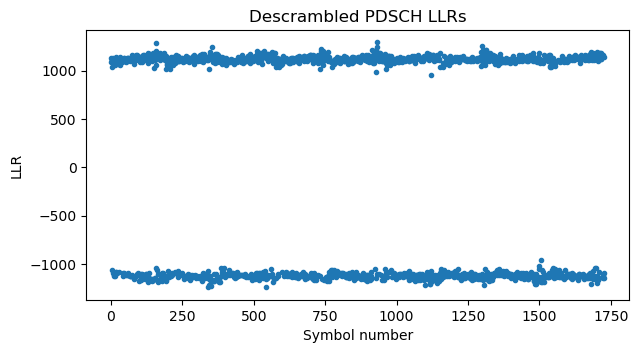

In [86]:
pdsch_non_dmrs = np.array([j for j in range(12) if j not in [0, 5, 9]])
pdsch_syms = symbols[10*140+14+np.arange(12), 128:224][pdsch_non_dmrs].ravel()
n_rnti = 0xffff  # SI-RNTI
pdsch_scrambling = 1 - 2 * c_seq(n_rnti * 2**15 + NcellID, 2 * pdsch_syms.size).astype('float')
pdsch_llrs = 2 * np.sqrt(0.5) / noise_sigma**2 * pdsch_syms.view('float') * pdsch_scrambling
plt.plot(pdsch_llrs, '.')
plt.title('Descrambled PDSCH LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

In [87]:
# TBS determination - TS 38.214 Section 5.1.3.2
NRB_sc = 12
Nsh_symb = 12
NPRB_DMRS = 12 * 3
NPRB_oh = 0
Nprime_RE = NRB_sc * Nsh_symb - NPRB_DMRS - NPRB_oh
n_PRB = (224 - 128) // 12
N_RE = min(156, Nprime_RE) * n_PRB
assert N_RE == pdsch_syms.size

# target coding rate R determined by MCS = 5 and TS 38.214 Table 5.1.3.1-1
R = 379 / 1024
Q_m = 2  # QPSK
nu = 1  # number of layers
N_info = N_RE * R * Q_m * nu
assert N_info <= 3824
# use step 3
n = max(3, int(np.log2(N_info)) - 6)
Nprime_info = max(24, 2**n * int(N_info / 2**n))
Nprime_info

632

In [88]:
# select TBS in Table 5.1.3.2-1
tbs = 640
tbs_index = 44

In [89]:
# LDPC code selection
# base graph 2 is used, because TBS <= 3824 and R <= 0.67

# code block segmentation
B = tbs + 16  # tbs <= 3824 -> CRC-16
K_cb = 3840  # base graph 2
assert B <= K_cb
L = 0
C = 1
Bprime = B
Kprime = Bprime / C
if B > 640:
    Kb = 10
elif B > 560:
    Kb = 9
elif B > 192:
    Kb = 8
else:
    Kb = 6
Kb, Kprime

(10, 656.0)

In [90]:
# choose lifting size as the smallest that satisfies Kb * Zc >= Kprime
Zcs = [2, 4, 8, 16, 32, 64, 128, 256, 3, 6, 12, 24, 48, 96, 192, 384, 5, 10, 20, 40, 80, 160, 320,
       7, 14, 28, 56, 112, 224, 9, 18, 36, 72, 144, 288, 11, 22, 44, 88, 176, 352, 13, 26, 52, 104, 208,
       15, 30, 60, 120, 240]
Zc = min([Zc for Zc in Zcs if Kb * Zc >= Kprime])
Zc

72

In [91]:
i_LS = 4

In [92]:
K = 10 * Zc
N = 50 * Zc

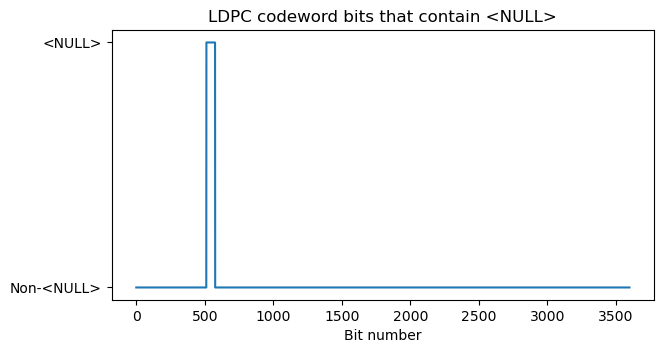

In [93]:
# calculation of where NULL bits get inserted
info_nulls = np.zeros(K, dtype='bool')
info_nulls[B:] = True
codeword_nulls = np.zeros(N, dtype='bool')
codeword_nulls[:K-2*Zc] = info_nulls[2*Zc:]
plt.plot(codeword_nulls)
plt.title('LDPC codeword bits that contain <NULL>')
plt.xlabel('Bit number')
plt.yticks([0, 1], ['Non-<NULL>', '<NULL>']);

In [94]:
rv = 0
# TS 38.212 Table 5.4.2.1-2 for base graph 2
N_cb = N
k0 = [0, int(13 * N_cb / (50 * Zc)) * Zc, int(25 * N_cb / (50 * Zc)) * Zc, int(43 * N_cb / (50 * Zc)) * Zc][rv]
E = pdsch_llrs.size
bit_selection_idx_out = np.zeros(E, 'int')
k = 0
j = 0
while k < E:
    if not codeword_nulls[(k0 + j) % N_cb]:
        bit_selection_idx_out[k] = (k0 + j) % N_cb
        k += 1
    j += 1

bit_interleaving_idx_out = bit_selection_idx_out.reshape(Q_m, -1).T.ravel()

In [95]:
bit_interleaving_idx_out

array([   0,  928,    1, ..., 1790,  927, 1791], shape=(1728,))

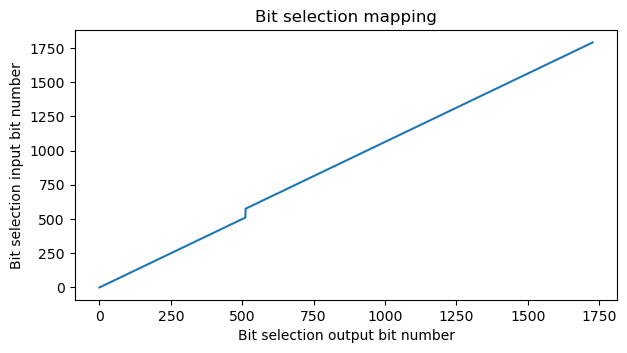

In [96]:
plt.plot(bit_selection_idx_out)
plt.title('Bit selection mapping')
plt.xlabel('Bit selection output bit number')
plt.ylabel('Bit selection input bit number');

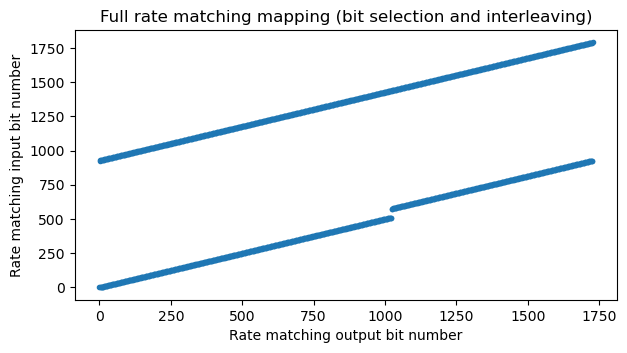

In [97]:
plt.plot(bit_interleaving_idx_out, '.')
plt.title('Full rate matching mapping (bit selection and interleaving)')
plt.xlabel('Rate matching output bit number')
plt.ylabel('Rate matching input bit number');

In [98]:
codeword_llrs = np.zeros(N)
for j, idx in enumerate(bit_interleaving_idx_out):
    codeword_llrs[idx] += pdsch_llrs[j]
codeword_llrs[codeword_nulls] = np.inf
# put back 2*Zc punctured information bits at the beginning
codeword_llrs = np.concatenate((np.zeros(2 * Zc), codeword_llrs))

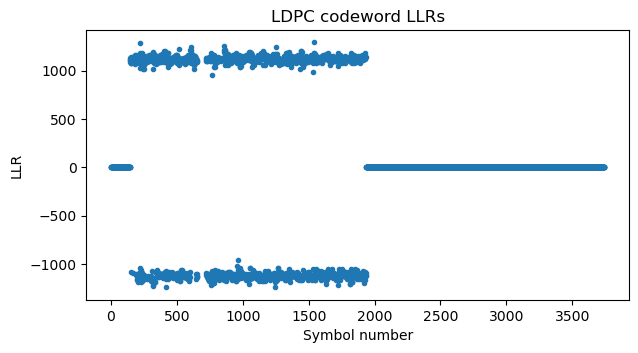

In [99]:
plt.plot(codeword_llrs, '.')
plt.title('LDPC codeword LLRs')
plt.xlabel('Symbol number')
plt.ylabel('LLR');

In [100]:
# build parity check matrix
toolbox_out = subprocess.run(['ldpc-toolbox', '5g', '--base-graph', '2', '--lifting-size', str(Zc)], capture_output=True)
alist = str(toolbox_out.stdout, encoding='ascii')
num_cols, num_rows = [int(a) for a in alist.split('\n')[0].split()]
H = np.zeros((num_rows, num_cols), dtype='int')
for col, col_rows in enumerate(alist.split('\n')[4:][:num_cols]):
    for row in col_rows.split():
        row = int(row) - 1
        if row == -1:
            continue
        H[row, col] = 1
H_by_rows = [[k for k in range(H.shape[1]) if H[j, k] == 1] for j in range(H.shape[0])]
H_by_cols = [[j for j in range(H.shape[0]) if H[j, k] == 1] for k in range(H.shape[1])]

LDPC decoder success


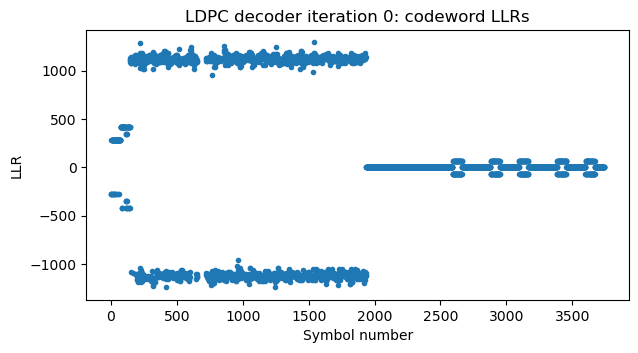

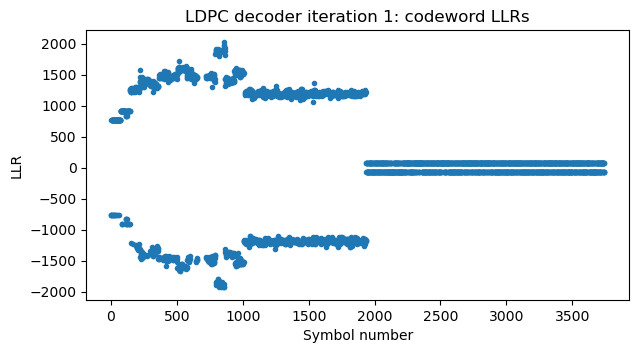

In [101]:
# Belief propagation algorithm

def phi(x):
    min_x = 1e-30
    # Ensure that x is not zero. Otherwise the output will be +inf, which gives
    # problems when computing (+inf) - (+inf).
    y = np.copy(x)
    y[x < min_x] = min_x
    return -np.log(np.tanh(0.5 * y))

# initialization
R = codeword_llrs
M = np.zeros(H.shape)
M[:] = R

max_iter = 20
for iteration in range(20):
    # check messages
    E = np.zeros(H.shape)
    for j in range(H.shape[0]):
        for k in range(H.shape[1]):
            if H[j, k] == 0:
                continue
            Ms = np.array([M[j, a] for a in H_by_rows[j] if a != k])
            E[j, k] = np.prod(np.sign(Ms)) * phi(np.sum(phi(np.abs(Ms))))
    # test
    L = np.sum(E, axis=0) + R
    plt.figure()
    plt.plot(L, '.')
    plt.title(f'LDPC decoder iteration {iteration}: codeword LLRs')
    plt.xlabel('Symbol number')
    plt.ylabel('LLR')
    c_hat = L <= 0
    if all(sum(c_hat[k] for k in Hrow) % 2 == 0 for Hrow in H_by_rows):
        print('LDPC decoder success')
        break
    # bit messages
    M = np.zeros(H.shape)
    for j in range(H.shape[0]):
        for k in range(H.shape[1]):
            if H[j, k] == 0:
                continue
            Es = np.array([E[a, k] for a in H_by_cols[k] if a != j])
            M[j, k] = np.sum(Es) + R[k]
else:
    print('LDPC decoder failure')

In [102]:
# pycrc --width 16 --poly 0x1021 --reflect-in false --reflect-out false --xor-in 0 --xor-out 0 --algorithm table-driven --generate c
crc16_table = [
    0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0
]

def crc16(data):
    crc = 0
    for d in data:
        tbl_idx = ((crc >> 8) ^ d) & 0xff
        crc = (crc16_table[tbl_idx] ^ (crc << 8)) & 0xffff
    return crc & 0xffff

In [103]:
transport_block_with_crc = np.packbits(c_hat[:B])
assert crc16(transport_block_with_crc) == 0
transport_block = transport_block_with_crc[:-2]

In [104]:
sib1_decoded = asn1.decode('BCCH-DL-SCH-Message', bytes(transport_block))
sib1_decoded

{'message': ('c1',
  ('systemInformationBlockType1',
   {'cellSelectionInfo': {'q-RxLevMin': -70, 'q-QualMin': -20},
    'cellAccessRelatedInfo': {'plmn-IdentityInfoList': [{'plmn-IdentityList': [{'mcc': [0,
          0,
          1],
         'mnc': [0, 1]}],
       'trackingAreaCode': (b'\x00\x00\x07', 24),
       'cellIdentity': (b'\x00\x00\x01\x9b\x00', 36),
       'cellReservedForOperatorUse': 'notReserved'}]},
    'connEstFailureControl': {'connEstFailCount': 'n1',
     'connEstFailOffsetValidity': 's30',
     'connEstFailOffset': 1},
    'servingCellConfigCommon': {'downlinkConfigCommon': {'frequencyInfoDL': {'frequencyBandList': [{'freqBandIndicatorNR': 3}],
       'offsetToPointA': 1,
       'scs-SpecificCarrierList': [{'offsetToCarrier': 0,
         'subcarrierSpacing': 'kHz15',
         'carrierBandwidth': 25}]},
      'initialDownlinkBWP': {'genericParameters': {'locationAndBandwidth': 6600,
        'subcarrierSpacing': 'kHz15'},
       'pdcch-ConfigCommon': ('setup',
     

In [116]:
RIV = (sib1_decoded['message'][1][1]['servingCellConfigCommon']['downlinkConfigCommon']['initialDownlinkBWP']
    ['genericParameters']['locationAndBandwidth'])
N_size_BWP = 275
a = RIV // N_size_BWP
b = RIV % N_size_BWP
assert a + b + 1 <= N_size_BWP
RBstart = b
Lrbs = a + 1
(RIV, RBstart, Lrbs)

(6600, 0, 25)

In [105]:
dataset.add_annotation(round(t_symbols[10*140+14] * fs - Ncp), 12 * Tu + 11 * Ncp + Ncpl, metadata = {
    SigMFFile.FLO_KEY: f_center + (128 - Tu//2 - 0.5) * 15e3 + cfo,
    SigMFFile.FHI_KEY: f_center + (224 - Tu//2 - 0.5) * 15e3 + cfo,
    SigMFFile.LABEL_KEY: 'PDSCH',
    SigMFFile.GENERATOR_KEY: GENERATOR,
    SigMFFile.COMMENT_KEY: f"""SIB1 BCCH-DL-SCH-Message

{sib1_decoded}""",
        SigMFFile.GENERATOR_KEY: GENERATOR,
    })

## PCAP output

In [106]:
# Format as UDP frame for wireshark
def mac_pdu_to_udp(subframe, mac_pdu, rnti):
    udp_mac_pdu = b'mac-nr'
    radio_type = 1  # FDD
    direction = 1  # downlink
    if rnti == None:
        rnti_type = 0  # PBCH (NO_RNTI)
    elif rnti == 0xffff:
        rnti_type = 4  # SI-RNTI
    elif rnti == 0xfffe:
        rnti_type = 1  # P-RNTI
    else:
        rnti_type = 3  # C-RNTI
    subframe += pbch_sfn[0] * 10
    sfn = subframe // 10
    slot = subframe % 10
    payload_tag = 0x1    
    rnti_tag = 0x2
    ueid_tag = 0x3
    subframe_tag = 0x4
    frame_slot_tag = 0x7
    udp_mac_pdu += bytes([radio_type, direction, rnti_type])
    if rnti is not None:
        udp_mac_pdu += bytes([rnti_tag, rnti >> 8, rnti & 0xff])
    if rnti_type == 3:
        # use C-RNTI as UE ID, since we don't have anything better
        udp_mac_pdu += bytes([ueid_tag, rnti >> 8, rnti & 0xff])
    udp_mac_pdu += bytes([frame_slot_tag, sfn >> 8, sfn & 0xff, slot >> 8, slot & 0xff])
    udp_mac_pdu += bytes([payload_tag])
    udp_mac_pdu += mac_pdu
    return udp_mac_pdu

wireshark_udp_packets = []
subframe_starts = t_symbols[::14] - (2*(Tu + Ncp) + Ncpl) / fs
subframe_starts = (subframe_starts * 1e9 * np.timedelta64(1, 'ns')
                   + np.datetime64(dataset.get_capture_info(0)[SigMFFile.DATETIME_KEY][:-1]))

def store_mac_pdu(subframe, mac_pdu, rnti):
    packet = (IP(src='127.0.0.1', dst='127.0.0.1')
              / UDP(sport=9999, dport=9999)
              / mac_pdu_to_udp(subframe, mac_pdu, rnti))
    packet.time = (subframe_starts[subframe] - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
    wireshark_udp_packets.append(packet)

In [107]:
for j in range(bch_msg.shape[0]):
    store_mac_pdu(10 * j, bytes(bch_msg[j]), None)
store_mac_pdu(101, bytes(transport_block), 0xffff)

In [108]:
# Save generated annotations
dataset.tofile(dataset_path)

In [109]:
# Save wireshark pcap
wireshark_udp_packets.sort(key=lambda packet: packet.time)
scapy.utils.wrpcap('nr-downlink.pcap', wireshark_udp_packets)